# Reproduction of Fig. 3

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.ticker import MultipleLocator
from Bio.Seq import reverse_complement
from pyscripts.config import path2
from pyscripts.datasets import Metadata
from pyscripts.genomeutil import bac_translate
from pyscripts.visualization import ColorUniversalDesign as CUD

metadata = Metadata()

In [2]:
nts_summary = pd.read_pickle(path2.data/'kmer'/'nts_summary.pkl.bz2')
codons_summary = pd.read_pickle(path2.data/'kmer'/'codons_summary.pkl.bz2')
bicodons_summary = pd.read_pickle(path2.data/'kmer'/'bicodons_summary.pkl.bz2')

In [3]:
codon_usage = codons_summary / codons_summary.groupby(bac_translate).transform('sum')

obs_bicodons = bicodons_summary
exp_bicodons = bicodons_summary.groupby(bac_translate).transform('sum') \
                * bicodons_summary.index.to_series().str[:3].apply(lambda c: codon_usage.loc[c]) \
                * bicodons_summary.index.to_series().str[3:].apply(lambda c: codon_usage.loc[c])

In [4]:
fw1 = lambda bc: bac_translate(bc[1:4])
fw2 = lambda bc: bac_translate(bc[2:5])
rc1 = lambda bc: bac_translate(reverse_complement(bc[1:4]))
rc2 = lambda bc: bac_translate(reverse_complement(bc[2:5]))

In [5]:
Z_stop = pd.DataFrame(dtype=float)
obs_stop = pd.DataFrame(dtype=float)
exp_stop = pd.DataFrame(dtype=float)

for frame, arf in zip(['+1','+2','-1','-2'], [fw1, fw2, rc1, rc2]):
    obs_aa = obs_bicodons.groupby(arf).sum()
    exp_aa = exp_bicodons.groupby(arf).sum()
    assert np.isclose(obs_aa.sum(), exp_aa.sum()).all()
    N = exp_aa.sum()
    
    obs_stop[frame] = obs_aa.loc['*'] / N
    exp_stop[frame] = exp_aa.loc['*'] / N
    
    Z_stop[frame] = (obs_stop - exp_stop)[frame] / np.sqrt((exp_stop[frame] - exp_stop[frame] ** 2) / (N - 1))
    

In [6]:
GC = nts_summary.T.eval('(G+C)/(G+C+A+T)*100')

In [7]:
gtdbrep2refseq = metadata.acc.set_index('gtdbrep')['refseq']
refseq2gtdbrep = metadata.acc.set_index('refseq')['gtdbrep']
acc_ordered = pd.DataFrame([
    (refseq_acc, gtdb_acc)
    for gtdb_acc in metadata.bac120_tree.iter_leaf_names() 
    if (refseq_acc := gtdbrep2refseq.get(gtdb_acc)) is not None
], columns=['refseq', 'gtdbrep'])
gtdb_taxonomy = metadata.taxrank_inuse.loc[acc_ordered['gtdbrep']]

phylum_counts = gtdb_taxonomy['phylum'].value_counts()[gtdb_taxonomy['phylum'].unique()]
top_idx = phylum_counts[phylum_counts >= 40].sort_values(ascending=False).index
phylum_masked = gtdb_taxonomy['phylum'].where(gtdb_taxonomy['phylum'].isin(top_idx), '(others)')
phylum_color = (phylum_counts.rank(method='first', ascending=False).astype(int)-1).apply(CUD.OkabeIto_cmap)

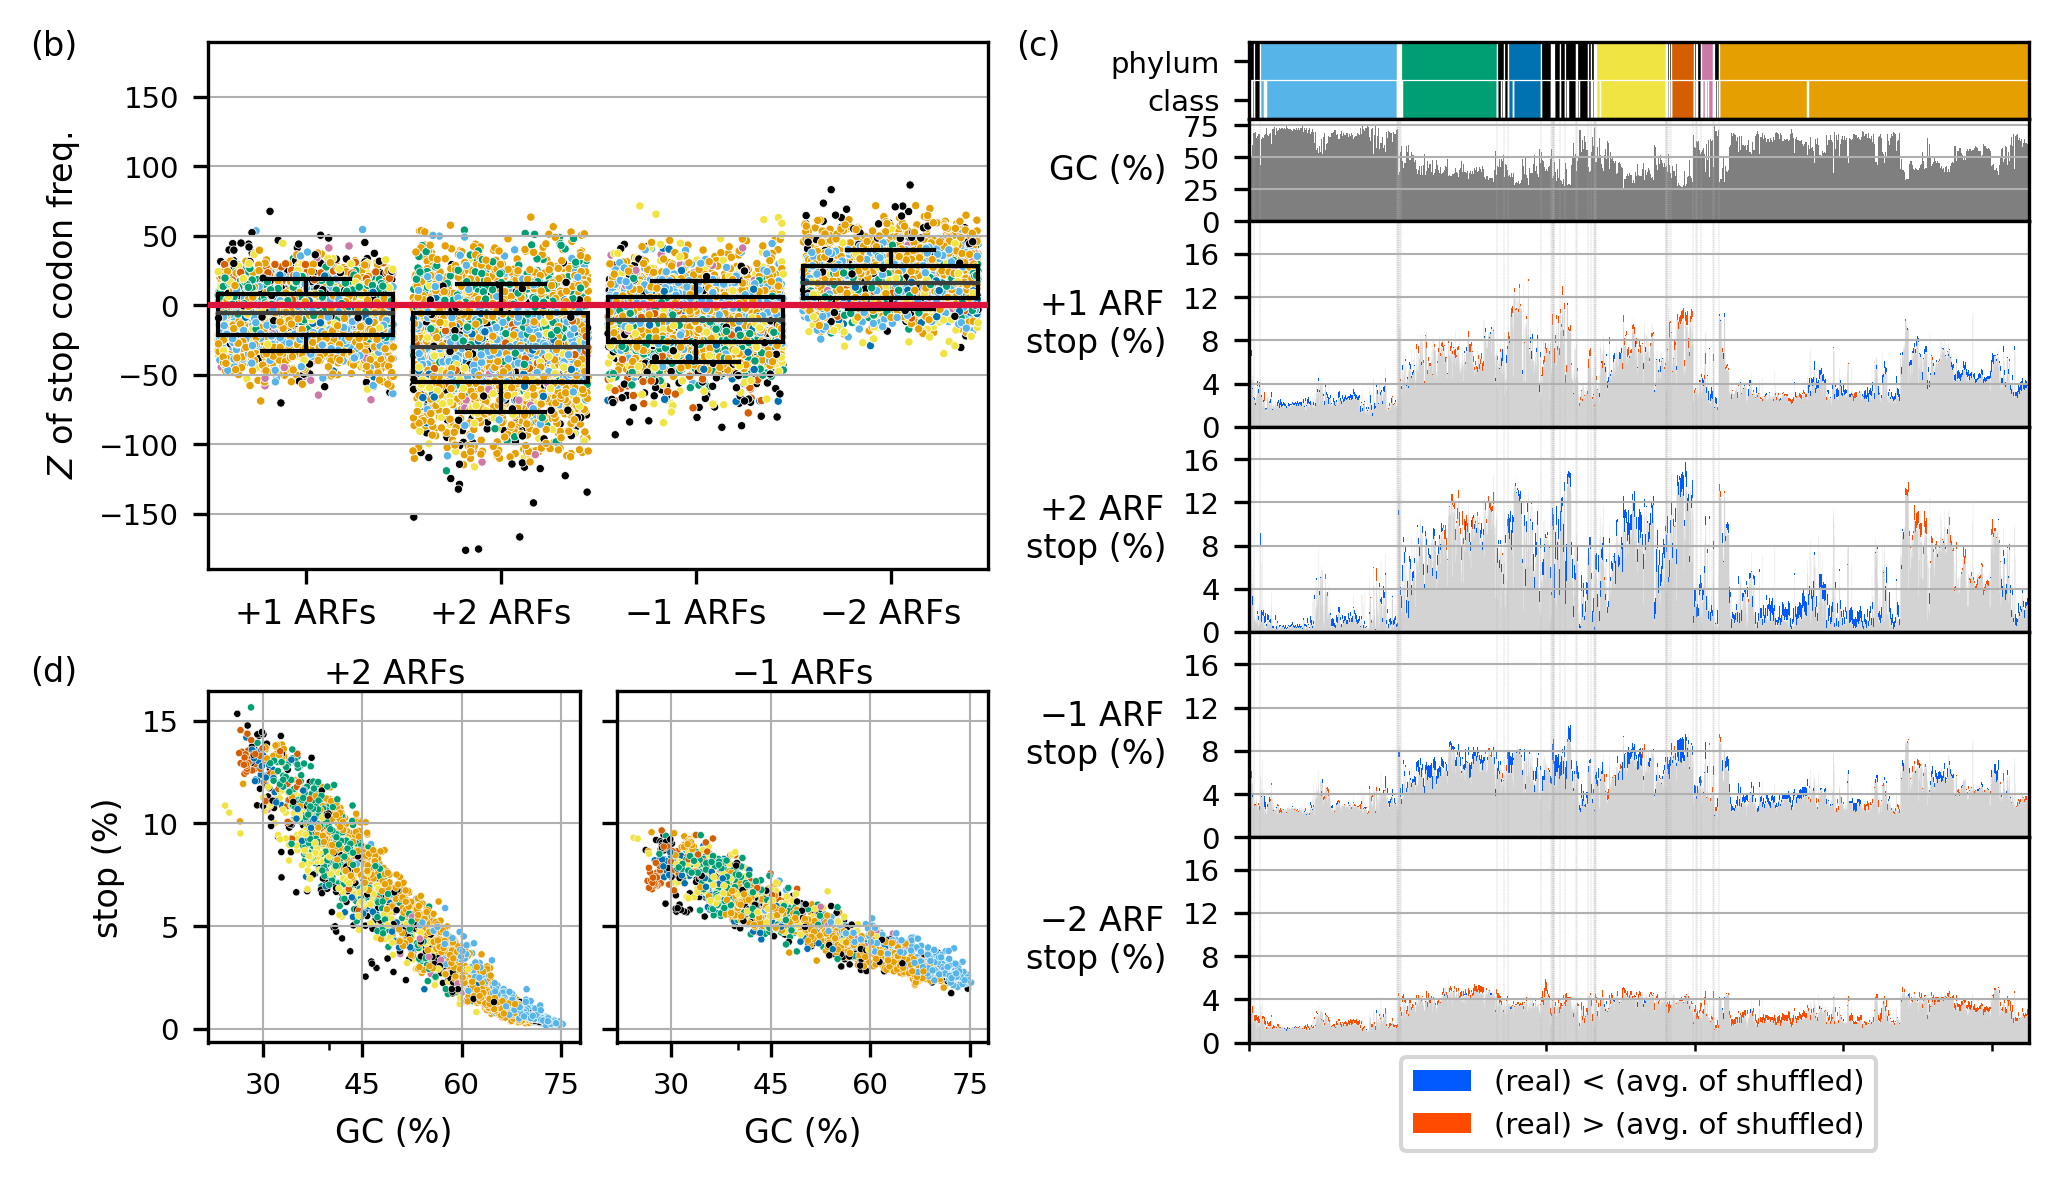

In [38]:
mm = 1 / 25.4

with plt.rc_context({'font.size': 8, 'grid.linewidth': 0.5, 'ytick.labelsize': 7}):
    fig = plt.figure(figsize=(174*mm, 100*mm), dpi=300)

    # Layout
    gs = GridSpec(1, 2)
    gs_bd  = GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 0], height_ratios=[3, 2], hspace=0.28, wspace=0.1)
    gs_c = GridSpecFromSubplotSpec(6, 1, subplot_spec=gs[0, 1], hspace=0, height_ratios=[0.75,1,2,2,2,2])
    ax_b = fig.add_subplot(gs_bd[0,:])
    axes_c, ax = [], None
    for gs_c_sub in gs_c:
        axes_c.append(ax:=fig.add_subplot(gs_c_sub, sharex=ax, sharey=ax if len(axes_c)>2 else None))
    axes_d = [
        (ax_d_fw2:=fig.add_subplot(gs_bd[1,0])),
        (ax_d_rc1:=fig.add_subplot(gs_bd[1,1], sharex=ax_d_fw2, sharey=ax_d_fw2))
    ]
    
    # Panel (b)
    ax = ax_b
    len_thresh, prob_thresh = 30, 0.5
    pltdata = Z_stop.rename_axis(index='gcf', columns='frame').stack().rename('Z').reset_index()
    pltdata = pltdata.assign(phylum=pltdata['gcf'].map(refseq2gtdbrep).map(phylum_masked))
    
    sns.boxplot(
        x='frame', y='Z', data=pltdata, order=['+1', '+2', '-1', '-2'], width=0.9,
        linewidth=1, ax=ax, capprops={'color':'k', 'zorder': 1}, whiskerprops={'color':'k', 'zorder': 1}, boxprops={'facecolor':'none', 'edgecolor':'k', 'zorder': 1}, whis=[10,90], fliersize=0
    )
    sns.stripplot(
        x='frame', y='Z', data=pltdata, order=['+1', '+2', '-1', '-2'],
        hue='phylum', hue_order=[*top_idx, '(others)'], palette=CUD.OkabeIto_cpal,
        jitter=0.45, s=2, ec='w', linewidth=0.2, ax=ax, zorder=0
    )
    ax.legend().remove()
    ax.axhline(0, c='crimson', zorder=10)
    ax.set_xlabel(None)
    ylim = max(map(abs, ax.get_ylim()))
    ax.set_ylim(-ylim, ylim),
    ax.set_ylabel('$Z$ of stop codon freq.')
    ax.set(
        xticks=[0, 1, 2, 3],
        xticklabels=['$+1$ ARFs', '$+2$ ARFs', '$-1$ ARFs', '$-2$ ARFs']
    )
    ax.yaxis.grid()
    ax.yaxis.set_major_locator(MultipleLocator(50))
    
    # Panel (c)
    ## phylogeny
    ax = axes_c[0]
    rect = []
    for w, x, fc in zip(phylum_counts, phylum_counts.cumsum(), phylum_color):
        rect.append(plt.Rectangle((x, 0), -w, 2, lw=0.3, ec='w', fc=fc))
    for p__, grp in gtdb_taxonomy.groupby('phylum'):
        base = (phylum_counts.cumsum() - phylum_counts)[p__]
        class_cnt = grp['class'].value_counts()[grp['class'].unique()]
        rect.extend([
            plt.Rectangle((base+x, 1), -w, 1, lw=0.3, ec='w', fc='None')
            for w, x in zip(class_cnt, class_cnt.cumsum())
        ])
    ax.add_collection(PatchCollection(rect, match_original=True))
    ax.set(xlim=(0, len(metadata.acc)), ylim=(2, 0))
    ax.set(yticks=[0.5, 1.5], yticklabels=['phylum', 'class'])
    ax.xaxis.set_tick_params(bottom=False, labelbottom=False)
    
    ## GC
    ax = axes_c[1]
    GC[acc_ordered['refseq']].plot.bar(ax=ax, width=1, fc='k', alpha=0.5)
    ylabel_props = dict(ha='right', va='center', rotation=0)
    ax.set_ylabel('GC (%)', **ylabel_props)
    ax.set_ylim(0, 80)
    ax.yaxis.set_major_locator(MultipleLocator(25))
    
    ## stop codons
    for frame, ax in zip(['+1', '+2', '-1', '-2'], axes_c[2:]):
        y1 = exp_stop.loc[acc_ordered['refseq'], frame] * 100
        y2 = obs_stop.loc[acc_ordered['refseq'], frame] * 100
        ax.fill_between(x=range(len(y1)), y1=[*map(min, zip(y1, y2))], y2=0, fc='lightgray', step='mid')
        #ax.plot(y1, c='lightgray', lw=0.5, ds='steps-mid', zorder=0)
        ax.fill_between(x=range(len(y1)), y1=y1, y2=y2, where=y2<y1, fc='#005aff', step='mid', label='(real) < (avg. of shuffled)', zorder=1)
        ax.fill_between(x=range(len(y1)), y1=y1, y2=y2, where=y1<y2, fc='#ff4b00', step='mid', label='(real) > (avg. of shuffled)', zorder=1)
        ax.set_ylim(0, 19)
        ax.yaxis.set_major_locator(MultipleLocator(4))
        ax.set_ylabel(f'${frame}$ ARF \nstop (%)', ha='right', va='center', rotation=0)
    else:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0), fontsize=7)
    ## common settings
    for ax in axes_c[1:]:
        ax.set_xticks(phylum_counts.cumsum())
        ax.xaxis.grid(ls='--', lw=0.1)
        ax.yaxis.grid()
        ax.set_xlabel(None)
        ax.xaxis.set_tick_params(bottom=False, labelbottom=False)
    
    # Panel (d)
    for frame, ax in zip(['+2', '-1'], axes_d):
        sns.scatterplot(
            x='GC', y=frame, hue='phylum', hue_order=[*top_idx, '(others)'], palette=CUD.OkabeIto_cpal, s=3, ax=ax,
            data=pd.concat([obs_stop[frame]*100, GC, refseq2gtdbrep.map(phylum_masked)], axis=1, keys=[frame, 'GC', 'phylum']),
        )
        ax.legend().remove()
        ax.set_xlabel('GC (%)', visible=True)
        ax.set_ylabel('stop (%)')
        ax.set_title(f'${frame}$ ARFs', pad=2, fontsize=8)
        ax.xaxis.set_major_locator(MultipleLocator(15))
        ax.xaxis.set_tick_params(bottom=True, labelbottom=True, labelsize=7)
        ax.grid()
        
    ax_d_rc1.set_ylabel(None)
    ax_d_rc1.yaxis.set_tick_params(labelleft=False)
    
    fig.text(0.01, 0.98, '(b)', va='top', ha='left')
    fig.text(0.49, 0.98, '(c)', va='top', ha='left')
    fig.text(0.01, 0.45, '(d)', va='top', ha='left')
    fig.tight_layout()
    fig.savefig('./Figs/Fig3bcd.pdf')

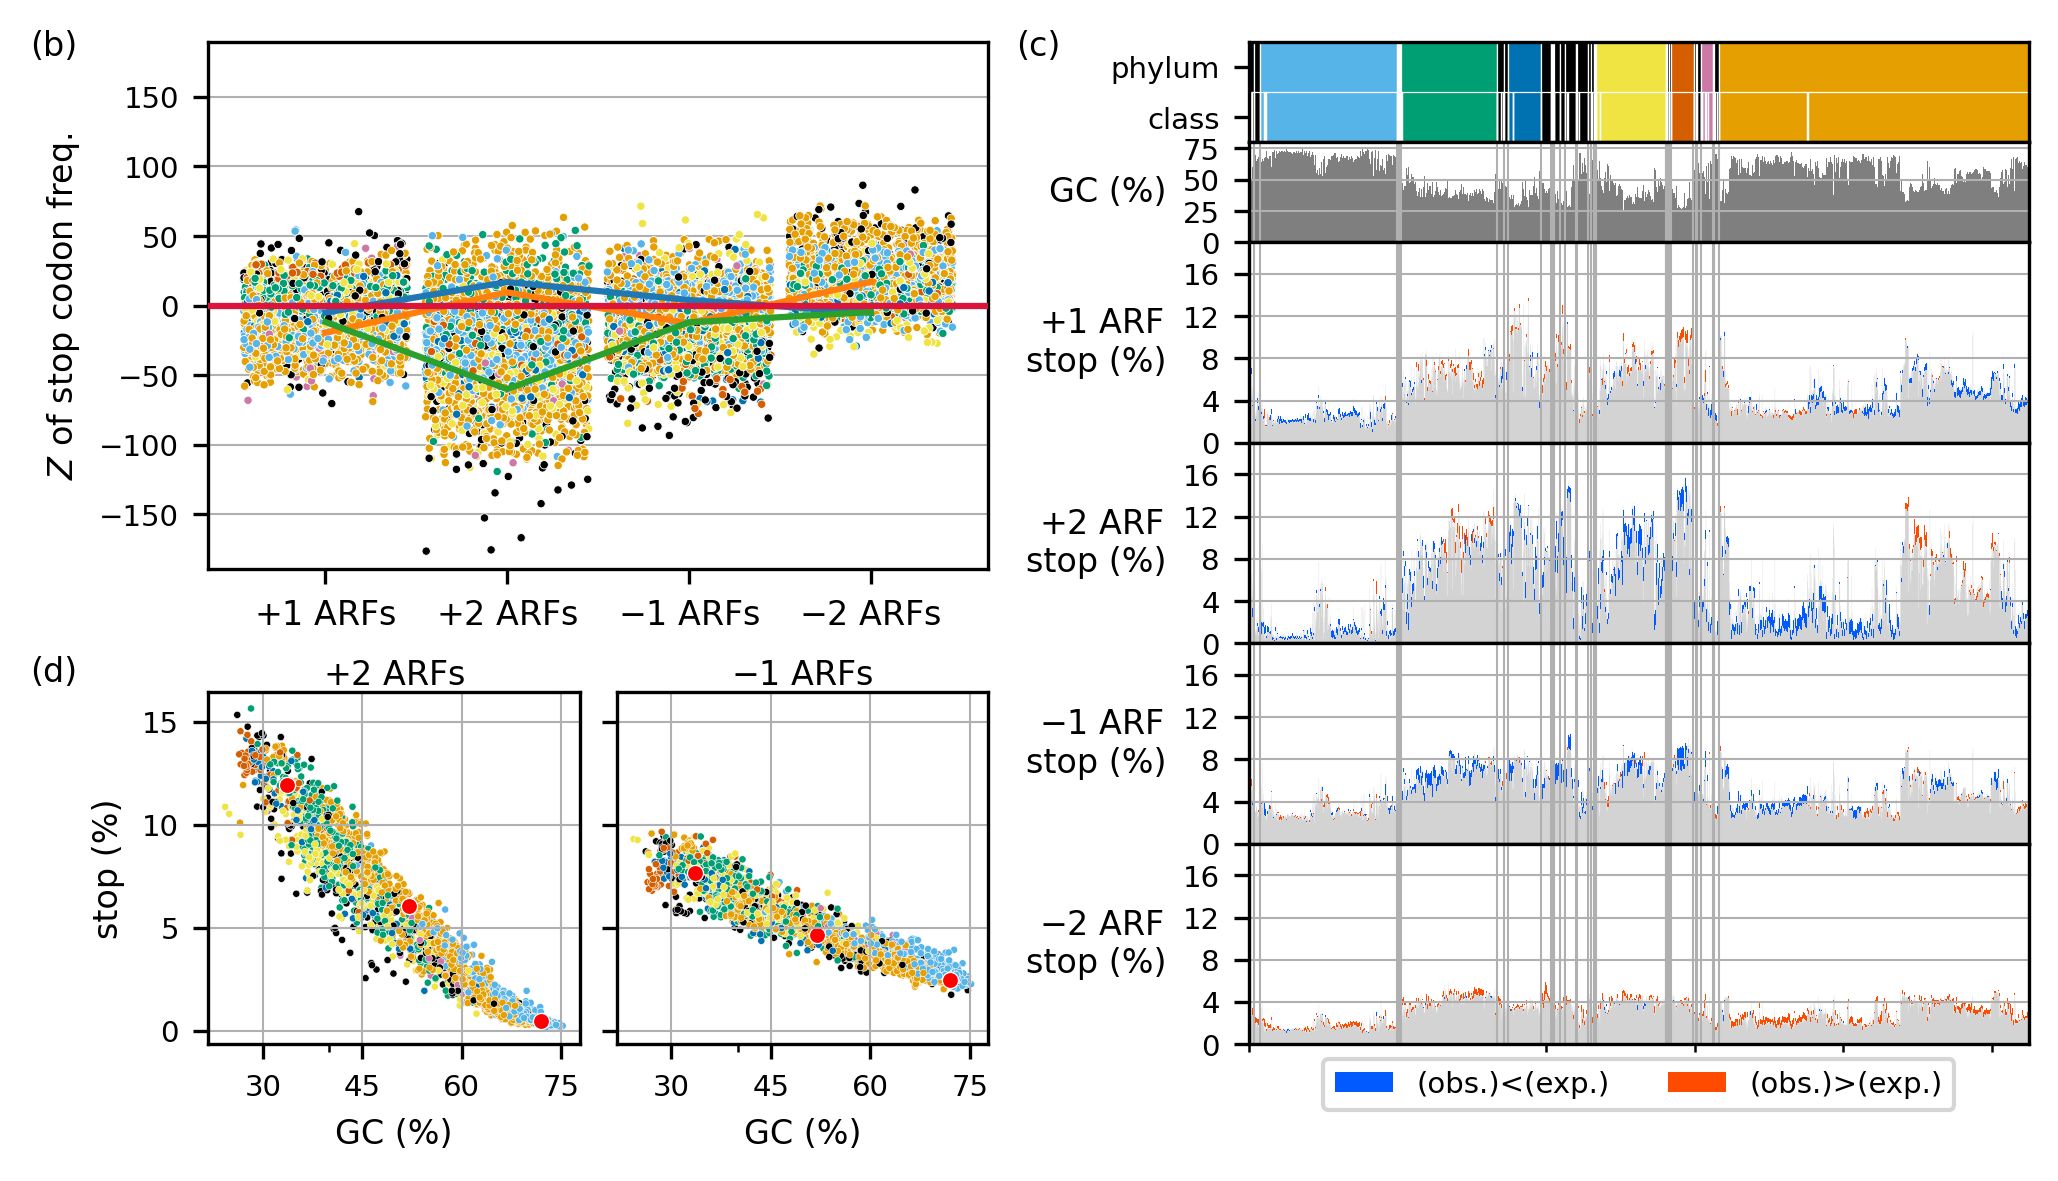

In [21]:
mm = 1 / 25.4

with plt.rc_context({'font.size': 8, 'grid.linewidth': 0.5, 'ytick.labelsize': 7}):
    fig = plt.figure(figsize=(174*mm, 100*mm), dpi=300)

    # Layout
    gs = GridSpec(1, 2)
    gs_bd  = GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 0], height_ratios=[3, 2], hspace=0.28, wspace=0.1)
    gs_c = GridSpecFromSubplotSpec(6, 1, subplot_spec=gs[0, 1], hspace=0, height_ratios=[1,1,2,2,2,2])
    ax_b = fig.add_subplot(gs_bd[0,:])
    axes_c, ax = [], None
    for gs_c_sub in gs_c:
        axes_c.append(ax:=fig.add_subplot(gs_c_sub, sharex=ax, sharey=ax if len(axes_c)>2 else None))
    axes_d = [
        (ax_d_fw2:=fig.add_subplot(gs_bd[1,0])),
        (ax_d_rc1:=fig.add_subplot(gs_bd[1,1], sharex=ax_d_fw2, sharey=ax_d_fw2))
    ]
    
    # Panel (b)
    ax = ax_b
    len_thresh, prob_thresh = 30, 0.5
    pltdata = Z_stop.rename_axis(index='gcf', columns='frame').stack().rename('Z').reset_index()
    pltdata = pltdata.assign(phylum=pltdata['gcf'].map(refseq2gtdbrep).map(phylum_masked))
    
    sns.stripplot(
        x='frame', y='Z', data=pltdata, order=['+1', '+2', '-1', '-2'],
        hue='phylum', hue_order=[*top_idx, '(others)'], palette=CUD.OkabeIto_cpal,
        jitter=0.45, s=2, ec='w', linewidth=0.2, ax=ax, 
    )
    Z_stop.loc[['GCF_000013425.1','GCF_000006925.2','GCF_003932715.1']].T.plot(ax=ax, zorder=10)
    
    ax.legend().remove()
    ax.axhline(0, c='crimson', zorder=10)
    ax.set_xlabel(None)
    ylim = max(map(abs, ax.get_ylim()))
    ax.set_ylim(-ylim, ylim),
    ax.set_ylabel('$Z$ of stop codon freq.')
    ax.set(
        xticks=[0, 1, 2, 3],
        xticklabels=['$+1$ ARFs', '$+2$ ARFs', '$-1$ ARFs', '$-2$ ARFs']
    )
    ax.yaxis.grid()
    ax.yaxis.set_major_locator(MultipleLocator(50))
    # Panel (c)
    ## phylogeny
    ax = axes_c[0]
    rect = []
    for w, x, fc in zip(phylum_counts, phylum_counts.cumsum(), phylum_color):
        rect.append(plt.Rectangle((x, 0), -w, 2, lw=0.3, ec='w', fc=fc))
    for p__, grp in gtdb_taxonomy.groupby('phylum'):
        base = (phylum_counts.cumsum() - phylum_counts)[p__]
        class_cnt = grp['class'].value_counts()[grp['class'].unique()]
        rect.extend([
            plt.Rectangle((base+x, 1), -w, 1, lw=0.3, ec='w', fc='None')
            for w, x in zip(class_cnt, class_cnt.cumsum())
        ])
    ax.add_collection(PatchCollection(rect, match_original=True))
    ax.set(xlim=(0, len(metadata.acc)), ylim=(2, 0))
    ax.set(yticks=[0.5, 1.5], yticklabels=['phylum', 'class'])
    ax.xaxis.set_tick_params(bottom=False, labelbottom=False)
    
    ## GC
    ax = axes_c[1]
    GC[acc_ordered['refseq']].plot.bar(ax=ax, width=1, fc='k', alpha=0.5)
    ylabel_props = dict(ha='right', va='center', rotation=0)
    ax.set_ylabel('GC (%)', **ylabel_props)
    ax.set_ylim(0, 80)
    ax.yaxis.set_major_locator(MultipleLocator(25))
    
    ## stop codons
    for frame, ax in zip(['+1', '+2', '-1', '-2'], axes_c[2:]):
        y1 = exp_stop.loc[acc_ordered['refseq'], frame] * 100
        y2 = obs_stop.loc[acc_ordered['refseq'], frame] * 100
        ax.fill_between(x=range(len(y1)), y1=y1, y2=0, fc='lightgray', step='mid')
        ax.fill_between(x=range(len(y1)), y1=y1, y2=y2, where=y2<y1, fc='#005aff', step='mid', label='(obs.)<(exp.)')
        ax.fill_between(x=range(len(y1)), y1=y1, y2=y2, where=y1<y2, fc='#ff4b00', step='mid', label='(obs.)>(exp.)')
        ax.set_ylim(0, 19)
        ax.yaxis.set_major_locator(MultipleLocator(4))
        ax.set_ylabel(f'${frame}$ ARF \nstop (%)', ha='right', va='center', rotation=0)
    else:
        ax.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 0), fontsize=7)
    ## common settings
    for ax in axes_c[1:]:
        ax.set_xticks(phylum_counts.cumsum())
        ax.grid()
        ax.set_xlabel(None)
        ax.xaxis.set_tick_params(bottom=False, labelbottom=False)
    
    # Panel (d)
    for frame, ax in zip(['+2', '-1'], axes_d):
        sns.scatterplot(
            x='GC', y=frame, hue='phylum', hue_order=[*top_idx, '(others)'], palette=CUD.OkabeIto_cpal, s=3, ax=ax,
            data=pd.concat([obs_stop[frame]*100, GC, refseq2gtdbrep.map(phylum_masked)], axis=1, keys=[frame, 'GC', 'phylum']),
        )
        sns.scatterplot(
            x='GC', y=frame, color='r', palette=CUD.OkabeIto_cpal, s=15, ax=ax,
            data=pd.concat([obs_stop.loc[['GCF_000013425.1','GCF_000006925.2','GCF_003932715.1'], frame]*100, GC], axis=1, keys=[frame, 'GC']).dropna(),
        )
        #Z_stop.loc[['GCF_000013425.1','GCF_000006925.2','GCF_003932715.1']].T.plot(ax=ax)
    
        ax.legend().remove()
        ax.set_xlabel('GC (%)', visible=True)
        ax.set_ylabel('stop (%)')
        ax.set_title(f'${frame}$ ARFs', pad=2, fontsize=8)
        ax.xaxis.set_major_locator(MultipleLocator(15))
        ax.xaxis.set_tick_params(bottom=True, labelbottom=True, labelsize=7)
        ax.grid()
        
    ax_d_rc1.set_ylabel(None)
    ax_d_rc1.yaxis.set_tick_params(labelleft=False)
    
    fig.text(0.01, 0.98, '(b)', va='top', ha='left')
    fig.text(0.49, 0.98, '(c)', va='top', ha='left')
    fig.text(0.01, 0.45, '(d)', va='top', ha='left')
    fig.tight_layout()
    fig.savefig('./Figs/Fig3bcd-tmp.pdf')

In [32]:
from Bio.Seq import translate

#translate('CGTCGAATTAGAATAAGA')
#translate('GTCGAATTAGAATAA')
#translate('TCGAATTAGAATAAG')

translate('AGCTTAATCTTATTC'[::-1])[::-1]

'RILIL'